# Packages import

## onetime installer

In [1]:
# !pip install matplotlib
# !pip install pandas
# !pip install bs4
# !pip install numpy
# !pip3 install nltk
# !pip install scipy==1.12
# !pip install gensim
# !pip install seaborn
# !pip install scikit-learn
# !pip install plotly
# !pip install sqlalchemy
# import nltk
# nltk.download('stopwords')
# !pip install requests

## import

In [2]:
#import all the necessary packages.
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import math
import time
import re
import random
import os
import seaborn as sns
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity  
from sklearn.metrics import pairwise_distances
from matplotlib import gridspec
from scipy.sparse import hstack
from scipy.linalg import triu
import plotly
import requests
from PIL import Image

plotly.offline.init_notebook_mode(connected=True)
warnings.filterwarnings("ignore")

# Data Import

In [3]:
data = pd.read_csv(r'D:\OneDrive - Birmingham City University\Individual Honours Project\Might need for individual prj\my_project\data\fashion products small\styles-nhii.csv')
print('Number of data points : ', data.shape[0], \
      'Number of features/variables:', data.shape[1])

print(data.columns)
data.head()

Number of data points :  44446 Number of features/variables: 10
Index(['id', 'gender', 'masterCategory', 'subCategory', 'articleType',
       'baseColour', 'season', 'year', 'usage', 'productDisplayName'],
      dtype='object')


,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012,Casual,Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016,Casual,Titan Women Silver Watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011,Casual,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012,Casual,Puma Men Grey T-shirt


Dropping:
- year (unrelated to the model)

In [4]:
data.drop(['year'], axis=1, inplace=True)
print ('Number of data points : ', data.shape[0], \
       'Number of features:', data.shape[1])
data.head()

Number of data points :  44446 Number of features: 9


,id,gender,masterCategory,subCategory,articleType,baseColour,season,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,Casual,Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,Casual,Titan Women Silver Watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,Casual,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,Casual,Puma Men Grey T-shirt


- adding image urls into the dataset

In [5]:
add_data = pd.read_csv(r'D:\OneDrive - Birmingham City University\Individual Honours Project\Might need for individual prj\my_project\data\fashion products small\images.csv')
print(add_data.columns)

Index(['filename', 'link'], dtype='object')


In [6]:
add_data['filename'] = add_data['filename'].apply(lambda x: x.split('.')[0])
add_data.rename(columns={'filename':'id'}, inplace=True)

print(add_data.columns)

Index(['id', 'link'], dtype='object')


In [7]:
# add the link column in add_data to data
data['id'] = data['id'].astype(str)
add_data['id'] = add_data['id'].astype(str)

data = pd.merge(data, add_data, on='id')

data.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,usage,productDisplayName,link
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,Casual,Turtle Check Men Navy Blue Shirt,http://assets.myntassets.com/v1/images/style/p...
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,Casual,Peter England Men Party Blue Jeans,http://assets.myntassets.com/v1/images/style/p...
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,Casual,Titan Women Silver Watch,http://assets.myntassets.com/v1/images/style/p...
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,Casual,Manchester United Men Solid Black Track Pants,http://assets.myntassets.com/v1/images/style/p...
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,Casual,Puma Men Grey T-shirt,http://assets.myntassets.com/v1/images/style/p...


In [8]:
# drop row with id = 31284
data = data[data.id != '31284']
# drop row with articleType = 'Suspenders', 'Bath Robe', 'Bra', 'Boxers', 'Booties', 'Briefs', 'Innerwear Vests', 'Shapewear', 'Trunk', 'Belts', 'Stockings', 'Tights'
data = data[~data['articleType'].isin(['Suspenders', 'Bath Robe', 'Bra', 'Boxers', 'Booties', 'Briefs', 'Innerwear Vests', 'Shapewear', 'Trunk', 'Belts','Stockings','Tights'])]
# drop row with productDisplayName that contains 'boy' or 'girl' or 'kid'
data = data[~data['productDisplayName'].str.contains('boy|girl|kid', case=False).fillna(False)]
# drop row with subCategory = 'Innerwear' or 'Loungewear and Nightwear'
data = data[~data['subCategory'].isin(['Innerwear','Loungewear and Nightwear'])]

# Data pre-processing

### Deleting null values

In [9]:
data = data.dropna()
print('Number of data points after dropping rows with any NULLs:', data.shape[0])

Number of data points after dropping rows with any NULLs: 38550


### Adding new column

In [10]:
# print all unique values of articleType in the alphabetical order
print(sorted(data['articleType'].unique()))
# print all unique values of articleType with masterCategory being apparel
apparel_article_types = sorted(data[data['masterCategory'] == 'Apparel']['articleType'].unique())
print(apparel_article_types)

# print all unique values of subCategory in the alphabetical order
print(sorted(data['subCategory'].unique()))
# print all unique values of subCategory with masterCategory being apparel
apparel_subCategory = sorted(data[data['masterCategory'] == 'Apparel']['subCategory'].unique())
print(apparel_subCategory)

['Accessory Gift Set', 'Backpacks', 'Bangle', 'Basketballs', 'Beauty Accessory', 'Blazers', 'Body Lotion', 'Body Wash and Scrub', 'Bracelet', 'Capris', 'Caps', 'Casual Shoes', 'Churidar', 'Clutches', 'Compact', 'Concealer', 'Cufflinks', 'Cushion Covers', 'Deodorant', 'Dresses', 'Duffel Bag', 'Dupatta', 'Earrings', 'Eye Cream', 'Eyeshadow', 'Face Moisturisers', 'Face Scrub and Exfoliator', 'Face Serum and Gel', 'Face Wash and Cleanser', 'Flats', 'Flip Flops', 'Footballs', 'Formal Shoes', 'Foundation and Primer', 'Fragrance Gift Set', 'Free Gifts', 'Gloves', 'Hair Accessory', 'Hair Colour', 'Handbags', 'Hat', 'Headband', 'Heels', 'Highlighter and Blush', 'Ipad', 'Jackets', 'Jeans', 'Jeggings', 'Jewellery Set', 'Jumpsuit', 'Kajal and Eyeliner', 'Key chain', 'Kurta Sets', 'Kurtas', 'Kurtis', 'Laptop Bag', 'Leggings', 'Lehenga Choli', 'Lip Care', 'Lip Gloss', 'Lip Liner', 'Lip Plumper', 'Lipstick', 'Makeup Remover', 'Mask and Peel', 'Mens Grooming Kit', 'Messenger Bag', 'Mobile Pouch', 'Muf

In [75]:
# make a loop to print all articleType for each subCategory, with the count of each articleType
for subCategory in apparel_subCategory:
    print("SubCategory:", subCategory)
    subCategory_data = data[data['subCategory'] == subCategory]
    articleType_counts = subCategory_data['articleType'].value_counts()
    print(articleType_counts)
    print()

SubCategory: Apparel Set
Series([], Name: count, dtype: int64)

SubCategory: Bottomwear
articleType
Shorts         324
Trousers       310
Track Pants    233
Jeans          216
Leggings       102
Capris          79
Skirts          70
Tracksuits      26
Jeggings        14
Name: count, dtype: int64

SubCategory: Dress
articleType
Dresses     255
Jumpsuit     16
Name: count, dtype: int64

SubCategory: Saree
Series([], Name: count, dtype: int64)

SubCategory: Topwear
articleType
Tshirts        4214
Shirts         1653
Tops            948
Sweatshirts     202
Jackets         198
Sweaters        191
Waistcoat        11
Dresses           2
Name: count, dtype: int64



In [77]:
# list out all the baseColour
print(sorted(data['baseColour'].unique()))

['beige', 'black', 'blue', 'bronze', 'brown', 'burgundy', 'charcoal', 'coffee brown', 'copper', 'cream', 'fluorescent green', 'gold', 'green', 'grey', 'grey melange', 'khaki', 'lavender', 'lime green', 'magenta', 'maroon', 'mauve', 'metallic', 'multi', 'mushroom brown', 'mustard', 'navy blue', 'nude', 'off white', 'olive', 'orange', 'peach', 'pink', 'purple', 'red', 'rose', 'rust', 'sea green', 'silver', 'skin', 'steel', 'tan', 'taupe', 'teal', 'turquoise blue', 'white', 'yellow']


In [12]:
# remove rows with articleType = 'Kurtas', 'Tunics', 'Kurtis', 'Dupatta', 'Sarees', 'Swimwear', 'Swimwear', 'Salwar', 'Churidar', 'Patiala', 'Kurta Sets'
data = data[~data['articleType'].isin(['Kurtas', 'Tunics', 'Kurtis', 'Dupatta', 'Sarees', 'Swimwear', 'Swimwear', 'Salwar', 'Churidar', 'Patiala', 'Kurta Sets'])]

In [13]:
def join_unique_words(row):
    product_display_name_words = set(str(row['productDisplayName']).split())
    words = set()  # A set to store unique words

    # Iterate over each column
    for col in row.index:
        if col not in ['id', 'productDisplayName', 'link', 'productDescription']:
            for word in str(row[col]).split():
                if word not in product_display_name_words:
                    words.add(word)

    return ' '.join(words)

# Apply the function to each row
data['productDescription'] = data.apply(join_unique_words, axis=1)

# Concatenate 'productDisplayName' and 'productDescription'
data['productDescription'] = data[['productDisplayName','productDescription']].astype(str).agg(' '.join, axis=1)

pd.set_option('display.max_colwidth', None)
print(data['productDescription'].head())
print(data['productDisplayName'].head())

0             Turtle Check Men Navy Blue Shirt Shirts Topwear Apparel Casual Fall
1             Peter England Men Party Blue Jeans Bottomwear Casual Summer Apparel
2                      Titan Women Silver Watch Casual Watches Accessories Winter
3    Manchester United Men Solid Black Track Pants Bottomwear Casual Fall Apparel
4                     Puma Men Grey T-shirt Topwear Tshirts Apparel Casual Summer
Name: productDescription, dtype: object
0                 Turtle Check Men Navy Blue Shirt
1               Peter England Men Party Blue Jeans
2                         Titan Women Silver Watch
3    Manchester United Men Solid Black Track Pants
4                            Puma Men Grey T-shirt
Name: productDisplayName, dtype: object


### Remove products with brief description

In [14]:
# Remove All products with very few words in title
data_sorted = data[data['productDescription'].apply(lambda x: len(x.split())>4)]
print("After removal of products with short description:", data_sorted.shape[0])

After removal of products with short description: 35505


### Removing products with dual titles per sort
1. The data is sorted based on the product description.
2. For each product, the code splits the product description into individual words.
3. The code then compares this product with the next one in the sorted list. If the number of differing words is more than 2, the products are considered different, and both are kept in the dataset. If the number of differing words is 2 or less, the products are considered the same, and the second product is removed from the dataset.
4. This process is repeated until all products have been compared.

In [15]:
print('The number of entries with duplicate title is %d'%sum(data.duplicated('productDescription')))
data_sorted.sort_values('productDescription',inplace=True, ascending=False)

indices = []
for i,row in data_sorted.iterrows():
    indices.append(i)
import itertools
stage1_dedupe_asins = []
i = 0
j = 0
num_data_points = data_sorted.shape[0]
while i < num_data_points and j < num_data_points:    
    previous_i = i
    a = data['productDescription'].loc[indices[i]].split()
    j = i+1
    while j < num_data_points:
        b = data['productDescription'].loc[indices[j]].split()
        length = max(len(a), len(b))
        count  = 0
        for k in itertools.zip_longest(a,b): 
            if (k[0] == k[1]):
                count += 1
        if (length - count) > 2:
            stage1_dedupe_asins.append(data_sorted['id'].loc[indices[i]])
            if j == num_data_points-1: stage1_dedupe_asins.append(data_sorted['id'].loc[indices[j]])
            i = j
            break
        else:
            j += 1
    if previous_i == i:
        break

data = data.loc[data['id'].isin(stage1_dedupe_asins)]
print('Number of data points now is: ', data.shape[0])

The number of entries with duplicate title is 8734
Number of data points now is:  21354


In [16]:
# count number of products in each articleType
articleType_counts = data['articleType'].value_counts()
# count number of products in each baseColour
baseColour_counts = data['baseColour'].value_counts()
print('Number of products in each articleType:', articleType_counts)
print('Number of products in each baseColour:', baseColour_counts)

Number of products in each articleType: articleType
Tshirts                4216
Casual Shoes           1730
Shirts                 1655
Sports Shoes           1528
Watches                1156
                       ... 
Mens Grooming Kit         1
Body Wash and Scrub       1
Suits                     1
Shoe Laces                1
Ipad                      1
Name: count, Length: 109, dtype: int64
Number of products in each baseColour: baseColour
Black                4212
White                2917
Blue                 2160
Grey                 1649
Brown                1481
Red                  1327
Navy Blue            1105
Green                 954
Purple                849
Pink                  828
Yellow                451
Silver                443
Beige                 310
Maroon                308
Gold                  288
Orange                267
Olive                 228
Cream                 191
Steel                 139
Multi                 118
Charcoal              114
Off W

In [17]:
# drop every row with articleType that has less than 10 products
data = data.groupby('articleType').filter(lambda x: len(x) >= 10)

# Text Preprocessing

In [18]:
# we use the list of stop words that are downloaded from nltk lib.
stop_words = set(stopwords.words('english'))
print ('list of stop words:', stop_words)

def nlp_preprocessing(total_text, index, column):
    if type(total_text) is not int:
        string = ""
        for words in total_text.split():
            # remove the special chars in review like '"#$@!%^&*()_+-~?>< etc.
            word = ("".join(e for e in words if e.isalnum()))
            # Conver all letters to lower-case
            word = word.lower()
            # stop-word removal
            if not word in stop_words:
                string += word + " "
        data[column][index] = string

list of stop words: {'only', 'than', 'further', 'couldn', 'there', 'you', "didn't", 'why', 'should', "isn't", 'your', 'yourself', 'haven', 'own', 'hadn', 'as', 'did', 've', "doesn't", 'down', 'an', 'because', 'about', 'hasn', 'where', 'shan', 'weren', 'with', 'will', 'y', 'too', 'i', 'but', "that'll", 'these', 'mightn', 'their', 'once', 'doing', 'were', 'more', 'am', 'for', 'the', 'most', 'such', 'how', 'if', 'under', 'being', "hadn't", 'over', 'myself', "you're", 'again', 'each', 'during', 'theirs', 'those', 'no', 'ain', 'didn', "weren't", 'until', "shan't", "wasn't", 'below', 'whom', 'into', 'of', "couldn't", 'not', 'wasn', 'them', 'ours', 'hers', 'won', 'him', 'his', 'or', 'aren', 'from', 'in', 'above', 'itself', 'been', 'through', 'while', 'and', 'some', "aren't", 'isn', 'here', 'are', 'to', 'on', 't', 'between', "it's", 'that', 'who', 'off', 'now', 'up', 'mustn', 'o', 'our', 'other', "you've", "wouldn't", 'had', 'she', 'yours', 'ourselves', 'at', 'against', 'can', 'any', "you'll",

In [19]:
import sys
np.set_printoptions(threshold=sys.maxsize)

In [20]:
data["baseColour"] = data["baseColour"].str.lower()

In [21]:
data.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,usage,productDisplayName,link,productDescription
0,15970,Men,Apparel,Topwear,Shirts,navy blue,Fall,Casual,Turtle Check Men Navy Blue Shirt,http://assets.myntassets.com/v1/images/style/properties/7a5b82d1372a7a5c6de67ae7a314fd91_images.jpg,Turtle Check Men Navy Blue Shirt Shirts Topwear Apparel Casual Fall
1,39386,Men,Apparel,Bottomwear,Jeans,blue,Summer,Casual,Peter England Men Party Blue Jeans,http://assets.myntassets.com/v1/images/style/properties/4850873d0c417e6480a26059f83aac29_images.jpg,Peter England Men Party Blue Jeans Bottomwear Casual Summer Apparel
3,21379,Men,Apparel,Bottomwear,Track Pants,black,Fall,Casual,Manchester United Men Solid Black Track Pants,http://assets.myntassets.com/v1/images/style/properties/8153dc35d9a5420eeb93922067137db6_images.jpg,Manchester United Men Solid Black Track Pants Bottomwear Casual Fall Apparel
4,53759,Men,Apparel,Topwear,Tshirts,grey,Summer,Casual,Puma Men Grey T-shirt,http://assets.myntassets.com/v1/images/style/properties/Puma-Men-Grey-T-shirt_32668f8a61454d0cc028a808cf21b383_images.jpg,Puma Men Grey T-shirt Topwear Tshirts Apparel Casual Summer
5,1855,Men,Apparel,Topwear,Tshirts,grey,Summer,Casual,Inkfruit Mens Chain Reaction T-shirt,http://assets.myntassets.com/v1/images/style/properties/9c1b19682ecf926c296f520d5d6e0972_images.jpg,Inkfruit Mens Chain Reaction T-shirt Topwear Tshirts Grey Apparel Casual Summer Men


In [22]:
unique = data['gender'].unique()
print(unique)
unique = data['masterCategory'].unique()
print(unique)
unique = data['subCategory'].unique()
print(unique)
unique = data['articleType'].unique()
print(unique)
unique = data['baseColour'].unique()
print(unique)

['Men' 'Women' 'Unisex' 'Girls' 'Boys']
['Apparel' 'Accessories' 'Footwear' 'Personal Care' 'Free Items'
 'Sporting Goods']
['Topwear' 'Bottomwear' 'Watches' 'Shoes' 'Flip Flops' 'Sandal'
 'Jewellery' 'Lips' 'Bags' 'Fragrance' 'Dress' 'Wallets' 'Eyewear'
 'Headwear' 'Mufflers' 'Skin Care' 'Makeup' 'Free Gifts' 'Socks'
 'Accessories' 'Scarves' 'Nails' 'Ties' 'Water Bottle' 'Skin' 'Cufflinks'
 'Hair' 'Stoles' 'Sports Equipment' 'Perfumes' 'Belts']
['Shirts' 'Jeans' 'Track Pants' 'Tshirts' 'Watches' 'Casual Shoes'
 'Flip Flops' 'Sandals' 'Sweatshirts' 'Formal Shoes' 'Bracelet' 'Lipstick'
 'Flats' 'Handbags' 'Waistcoat' 'Sports Shoes' 'Shorts'
 'Perfume and Body Mist' 'Heels' 'Laptop Bag' 'Tops' 'Dresses' 'Skirts'
 'Wallets' 'Clutches' 'Backpacks' 'Trousers' 'Sunglasses' 'Deodorant'
 'Lip Gloss' 'Caps' 'Mufflers' 'Jackets' 'Face Wash and Cleanser'
 'Necklace and Chains' 'Sports Sandals' 'Foundation and Primer'
 'Free Gifts' 'Socks' 'Tracksuits' 'Capris' 'Fragrance Gift Set'
 'Duffel Bag' '

In [23]:
# print all unique values of articleType with the masterCategory 'Apparel'
print(sorted(data[data['masterCategory']=='Apparel']['articleType'].unique()))

['Capris', 'Dresses', 'Jackets', 'Jeans', 'Jeggings', 'Jumpsuit', 'Leggings', 'Shirts', 'Shorts', 'Skirts', 'Sweaters', 'Sweatshirts', 'Tops', 'Track Pants', 'Tracksuits', 'Trousers', 'Tshirts', 'Waistcoat']


# print all unique values of articleType with the 

In [24]:
start_time = time.time()
# we take each title and we text-preprocess it.
for index, row in data.iterrows():
    nlp_preprocessing(row['productDescription'], index, 'productDescription')
# we print the time it took to preprocess whole titles 
print(time.time() - start_time, "seconds")

data.head()

21.965268850326538 seconds


,id,gender,masterCategory,subCategory,articleType,baseColour,season,usage,productDisplayName,link,productDescription
0,15970,Men,Apparel,Topwear,Shirts,navy blue,Fall,Casual,Turtle Check Men Navy Blue Shirt,http://assets.myntassets.com/v1/images/style/properties/7a5b82d1372a7a5c6de67ae7a314fd91_images.jpg,turtle check men navy blue shirt shirts topwear apparel casual fall
1,39386,Men,Apparel,Bottomwear,Jeans,blue,Summer,Casual,Peter England Men Party Blue Jeans,http://assets.myntassets.com/v1/images/style/properties/4850873d0c417e6480a26059f83aac29_images.jpg,peter england men party blue jeans bottomwear casual summer apparel
3,21379,Men,Apparel,Bottomwear,Track Pants,black,Fall,Casual,Manchester United Men Solid Black Track Pants,http://assets.myntassets.com/v1/images/style/properties/8153dc35d9a5420eeb93922067137db6_images.jpg,manchester united men solid black track pants bottomwear casual fall apparel
4,53759,Men,Apparel,Topwear,Tshirts,grey,Summer,Casual,Puma Men Grey T-shirt,http://assets.myntassets.com/v1/images/style/properties/Puma-Men-Grey-T-shirt_32668f8a61454d0cc028a808cf21b383_images.jpg,puma men grey tshirt topwear tshirts apparel casual summer
5,1855,Men,Apparel,Topwear,Tshirts,grey,Summer,Casual,Inkfruit Mens Chain Reaction T-shirt,http://assets.myntassets.com/v1/images/style/properties/9c1b19682ecf926c296f520d5d6e0972_images.jpg,inkfruit mens chain reaction tshirt topwear tshirts grey apparel casual summer men


In [25]:
data.reset_index(inplace=True)

In [26]:
data.drop("index",axis=1,inplace=True)

In [27]:
data['baseColour'] = data['baseColour'].astype(str)

In [28]:
def convrt_remove_dup(x):
    x =x.split(",")
    x = list(dict.fromkeys(x))
    x = ",".join(x)
    return x

In [29]:
data["baseColour"] = data["baseColour"].apply(lambda x: convrt_remove_dup(x))

In [30]:
data['baseColour'] = data['baseColour'].astype(str)

In [31]:
len(data["baseColour"].unique())

46

In [32]:
pd.set_option("display.max_colwidth", None)

In [33]:
data.index[data['id'] == '48123'].tolist()

[]

In [34]:
data["link"].describe()

count         21232
unique        21227
top       undefined
freq              4
Name: link, dtype: object

In [35]:
# drop all undefined links
data = data[data['link'] != 'undefined']
data["link"].describe()

count                                                                                                   21228
unique                                                                                                  21226
top       http://assets.myntassets.com/v1/images/style/properties/588ca3614eb1f2b165346029efb0ae80_images.jpg
freq                                                                                                        2
Name: link, dtype: object

In [36]:
# drop duplicate links
data = data.drop_duplicates(subset='link', keep='first')

In [37]:
data.describe()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,usage,productDisplayName,link,productDescription
count,21226,21226,21226,21226,21226,21226,21226,21226,21226,21226,21226
unique,21226,5,6,31,75,46,4,7,20746,21226,21137
top,15970,Men,Apparel,Topwear,Tshirts,black,Summer,Casual,Lino Perros Men Pack of 2 Socks,http://assets.myntassets.com/v1/images/style/properties/7a5b82d1372a7a5c6de67ae7a314fd91_images.jpg,adidas men white polo tshirt sports topwear tshirts apparel fall
freq,1,11760,9064,7419,4215,4184,9692,16904,5,1,3


In [38]:
data.reset_index(inplace=True)

In [39]:
data.drop("index",axis=1,inplace=True)
data

,id,gender,masterCategory,subCategory,articleType,baseColour,season,usage,productDisplayName,link,productDescription
0,15970,Men,Apparel,Topwear,Shirts,navy blue,Fall,Casual,Turtle Check Men Navy Blue Shirt,http://assets.myntassets.com/v1/images/style/properties/7a5b82d1372a7a5c6de67ae7a314fd91_images.jpg,turtle check men navy blue shirt shirts topwear apparel casual fall
1,39386,Men,Apparel,Bottomwear,Jeans,blue,Summer,Casual,Peter England Men Party Blue Jeans,http://assets.myntassets.com/v1/images/style/properties/4850873d0c417e6480a26059f83aac29_images.jpg,peter england men party blue jeans bottomwear casual summer apparel
2,21379,Men,Apparel,Bottomwear,Track Pants,black,Fall,Casual,Manchester United Men Solid Black Track Pants,http://assets.myntassets.com/v1/images/style/properties/8153dc35d9a5420eeb93922067137db6_images.jpg,manchester united men solid black track pants bottomwear casual fall apparel
3,53759,Men,Apparel,Topwear,Tshirts,grey,Summer,Casual,Puma Men Grey T-shirt,http://assets.myntassets.com/v1/images/style/properties/Puma-Men-Grey-T-shirt_32668f8a61454d0cc028a808cf21b383_images.jpg,puma men grey tshirt topwear tshirts apparel casual summer
4,1855,Men,Apparel,Topwear,Tshirts,grey,Summer,Casual,Inkfruit Mens Chain Reaction T-shirt,http://assets.myntassets.com/v1/images/style/properties/9c1b19682ecf926c296f520d5d6e0972_images.jpg,inkfruit mens chain reaction tshirt topwear tshirts grey apparel casual summer men
...,...,...,...,...,...,...,...,...,...,...,...
21221,55283,Women,Personal Care,Makeup,Highlighter and Blush,pink,Spring,Casual,Lakme Absolute Cheek Chromatic Day Blushes Blusher,http://assets.myntassets.com/v1/images/style/properties/Lakme-Absolute-Cheek-Chromatic-Day-Blushes-Blusher_8c6dd26b9334d5ca052f94811cce653c_images.jpg,lakme absolute cheek chromatic day blushes blusher makeup blush women casual pink personal spring highlighter care
21222,6461,Men,Footwear,Flip Flops,Flip Flops,red,Summer,Casual,Lotto Men's Soccer Track Flip Flop,http://assets.myntassets.com/v1/images/style/properties/7cde05e9f595139fd7cd9b821200259f_images.jpg,lotto mens soccer track flip flop casual summer footwear men flops red
21223,18842,Men,Apparel,Topwear,Tshirts,blue,Fall,Casual,Puma Men Graphic Stellar Blue Tshirt,http://assets.myntassets.com/v1/images/style/properties/e75923d709a7c7c200448642e22f0841_images.jpg,puma men graphic stellar blue tshirt topwear tshirts apparel casual fall
21224,46694,Women,Personal Care,Fragrance,Perfume and Body Mist,blue,Spring,Casual,Rasasi Women Blue Lady Perfume,http://assets.myntassets.com/v1/images/style/properties/c7978c0dcc82aeba1a85268aebf28567_images.jpg,rasasi women blue lady perfume body casual personal spring fragrance mist care


In [40]:
import os
import pandas as pd

cwd = os.getcwd()
print(cwd)
file_path = cwd + "\\clothingdata_final.csv"

data.to_csv(file_path)

d:\OneDrive - Birmingham City University\Individual Honours Project\Might need for individual prj\my_project\notebooks


In [41]:
df = pd.read_csv(file_path)
df

,Unnamed: 0,id,gender,masterCategory,subCategory,articleType,baseColour,season,usage,productDisplayName,link,productDescription
0,0,15970,Men,Apparel,Topwear,Shirts,navy blue,Fall,Casual,Turtle Check Men Navy Blue Shirt,http://assets.myntassets.com/v1/images/style/properties/7a5b82d1372a7a5c6de67ae7a314fd91_images.jpg,turtle check men navy blue shirt shirts topwear apparel casual fall
1,1,39386,Men,Apparel,Bottomwear,Jeans,blue,Summer,Casual,Peter England Men Party Blue Jeans,http://assets.myntassets.com/v1/images/style/properties/4850873d0c417e6480a26059f83aac29_images.jpg,peter england men party blue jeans bottomwear casual summer apparel
2,2,21379,Men,Apparel,Bottomwear,Track Pants,black,Fall,Casual,Manchester United Men Solid Black Track Pants,http://assets.myntassets.com/v1/images/style/properties/8153dc35d9a5420eeb93922067137db6_images.jpg,manchester united men solid black track pants bottomwear casual fall apparel
3,3,53759,Men,Apparel,Topwear,Tshirts,grey,Summer,Casual,Puma Men Grey T-shirt,http://assets.myntassets.com/v1/images/style/properties/Puma-Men-Grey-T-shirt_32668f8a61454d0cc028a808cf21b383_images.jpg,puma men grey tshirt topwear tshirts apparel casual summer
4,4,1855,Men,Apparel,Topwear,Tshirts,grey,Summer,Casual,Inkfruit Mens Chain Reaction T-shirt,http://assets.myntassets.com/v1/images/style/properties/9c1b19682ecf926c296f520d5d6e0972_images.jpg,inkfruit mens chain reaction tshirt topwear tshirts grey apparel casual summer men
...,...,...,...,...,...,...,...,...,...,...,...,...
21221,21221,55283,Women,Personal Care,Makeup,Highlighter and Blush,pink,Spring,Casual,Lakme Absolute Cheek Chromatic Day Blushes Blusher,http://assets.myntassets.com/v1/images/style/properties/Lakme-Absolute-Cheek-Chromatic-Day-Blushes-Blusher_8c6dd26b9334d5ca052f94811cce653c_images.jpg,lakme absolute cheek chromatic day blushes blusher makeup blush women casual pink personal spring highlighter care
21222,21222,6461,Men,Footwear,Flip Flops,Flip Flops,red,Summer,Casual,Lotto Men's Soccer Track Flip Flop,http://assets.myntassets.com/v1/images/style/properties/7cde05e9f595139fd7cd9b821200259f_images.jpg,lotto mens soccer track flip flop casual summer footwear men flops red
21223,21223,18842,Men,Apparel,Topwear,Tshirts,blue,Fall,Casual,Puma Men Graphic Stellar Blue Tshirt,http://assets.myntassets.com/v1/images/style/properties/e75923d709a7c7c200448642e22f0841_images.jpg,puma men graphic stellar blue tshirt topwear tshirts apparel casual fall
21224,21224,46694,Women,Personal Care,Fragrance,Perfume and Body Mist,blue,Spring,Casual,Rasasi Women Blue Lady Perfume,http://assets.myntassets.com/v1/images/style/properties/c7978c0dcc82aeba1a85268aebf28567_images.jpg,rasasi women blue lady perfume body casual personal spring fragrance mist care


In [42]:
df.drop(["Unnamed: 0"],axis=1,inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21226 entries, 0 to 21225
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   id                  21226 non-null  int64 
 1   gender              21226 non-null  object
 2   masterCategory      21226 non-null  object
 3   subCategory         21226 non-null  object
 4   articleType         21226 non-null  object
 5   baseColour          21226 non-null  object
 6   season              21226 non-null  object
 7   usage               21226 non-null  object
 8   productDisplayName  21226 non-null  object
 9   link                21226 non-null  object
 10  productDescription  21226 non-null  object
dtypes: int64(1), object(10)
memory usage: 1.8+ MB


In [43]:
df.reset_index(inplace=True)

In [44]:
df.drop('index',axis=1,inplace=True)

In [45]:
df.rename(columns={"level_0": "id"},inplace=True)
df

,id,gender,masterCategory,subCategory,articleType,baseColour,season,usage,productDisplayName,link,productDescription
0,15970,Men,Apparel,Topwear,Shirts,navy blue,Fall,Casual,Turtle Check Men Navy Blue Shirt,http://assets.myntassets.com/v1/images/style/properties/7a5b82d1372a7a5c6de67ae7a314fd91_images.jpg,turtle check men navy blue shirt shirts topwear apparel casual fall
1,39386,Men,Apparel,Bottomwear,Jeans,blue,Summer,Casual,Peter England Men Party Blue Jeans,http://assets.myntassets.com/v1/images/style/properties/4850873d0c417e6480a26059f83aac29_images.jpg,peter england men party blue jeans bottomwear casual summer apparel
2,21379,Men,Apparel,Bottomwear,Track Pants,black,Fall,Casual,Manchester United Men Solid Black Track Pants,http://assets.myntassets.com/v1/images/style/properties/8153dc35d9a5420eeb93922067137db6_images.jpg,manchester united men solid black track pants bottomwear casual fall apparel
3,53759,Men,Apparel,Topwear,Tshirts,grey,Summer,Casual,Puma Men Grey T-shirt,http://assets.myntassets.com/v1/images/style/properties/Puma-Men-Grey-T-shirt_32668f8a61454d0cc028a808cf21b383_images.jpg,puma men grey tshirt topwear tshirts apparel casual summer
4,1855,Men,Apparel,Topwear,Tshirts,grey,Summer,Casual,Inkfruit Mens Chain Reaction T-shirt,http://assets.myntassets.com/v1/images/style/properties/9c1b19682ecf926c296f520d5d6e0972_images.jpg,inkfruit mens chain reaction tshirt topwear tshirts grey apparel casual summer men
...,...,...,...,...,...,...,...,...,...,...,...
21221,55283,Women,Personal Care,Makeup,Highlighter and Blush,pink,Spring,Casual,Lakme Absolute Cheek Chromatic Day Blushes Blusher,http://assets.myntassets.com/v1/images/style/properties/Lakme-Absolute-Cheek-Chromatic-Day-Blushes-Blusher_8c6dd26b9334d5ca052f94811cce653c_images.jpg,lakme absolute cheek chromatic day blushes blusher makeup blush women casual pink personal spring highlighter care
21222,6461,Men,Footwear,Flip Flops,Flip Flops,red,Summer,Casual,Lotto Men's Soccer Track Flip Flop,http://assets.myntassets.com/v1/images/style/properties/7cde05e9f595139fd7cd9b821200259f_images.jpg,lotto mens soccer track flip flop casual summer footwear men flops red
21223,18842,Men,Apparel,Topwear,Tshirts,blue,Fall,Casual,Puma Men Graphic Stellar Blue Tshirt,http://assets.myntassets.com/v1/images/style/properties/e75923d709a7c7c200448642e22f0841_images.jpg,puma men graphic stellar blue tshirt topwear tshirts apparel casual fall
21224,46694,Women,Personal Care,Fragrance,Perfume and Body Mist,blue,Spring,Casual,Rasasi Women Blue Lady Perfume,http://assets.myntassets.com/v1/images/style/properties/c7978c0dcc82aeba1a85268aebf28567_images.jpg,rasasi women blue lady perfume body casual personal spring fragrance mist care


DATA Connection

In [46]:
import sqlite3
conn = sqlite3.connect('clothing_db.sqlite3')
c = conn.cursor()

# list all columns of df
print(df.columns)

Index(['id', 'gender', 'masterCategory', 'subCategory', 'articleType',
       'baseColour', 'season', 'usage', 'productDisplayName', 'link',
       'productDescription'],
      dtype='object')


In [47]:
c.execute('CREATE TABLE IF NOT EXISTS store_product (id integer, gender text, masterCategory text, subCategory text, articleType text, baseColour text, season text, usage text, productDisplayName text, link text, productDescription text)')

conn.commit()
df.to_sql('store_product', conn, if_exists='replace', index = False)
conn.close()
df.to_csv("clothingdata_finalx.csv")

DATA EXTRACT

In [48]:
from sqlalchemy import create_engine

cnx = create_engine('sqlite:///clothing_db.sqlite3').connect()

dataframe_store_product = pd.read_sql_table('store_product', cnx)
dataframe_store_product

,id,gender,masterCategory,subCategory,articleType,baseColour,season,usage,productDisplayName,link,productDescription
0,15970,Men,Apparel,Topwear,Shirts,navy blue,Fall,Casual,Turtle Check Men Navy Blue Shirt,http://assets.myntassets.com/v1/images/style/properties/7a5b82d1372a7a5c6de67ae7a314fd91_images.jpg,turtle check men navy blue shirt shirts topwear apparel casual fall
1,39386,Men,Apparel,Bottomwear,Jeans,blue,Summer,Casual,Peter England Men Party Blue Jeans,http://assets.myntassets.com/v1/images/style/properties/4850873d0c417e6480a26059f83aac29_images.jpg,peter england men party blue jeans bottomwear casual summer apparel
2,21379,Men,Apparel,Bottomwear,Track Pants,black,Fall,Casual,Manchester United Men Solid Black Track Pants,http://assets.myntassets.com/v1/images/style/properties/8153dc35d9a5420eeb93922067137db6_images.jpg,manchester united men solid black track pants bottomwear casual fall apparel
3,53759,Men,Apparel,Topwear,Tshirts,grey,Summer,Casual,Puma Men Grey T-shirt,http://assets.myntassets.com/v1/images/style/properties/Puma-Men-Grey-T-shirt_32668f8a61454d0cc028a808cf21b383_images.jpg,puma men grey tshirt topwear tshirts apparel casual summer
4,1855,Men,Apparel,Topwear,Tshirts,grey,Summer,Casual,Inkfruit Mens Chain Reaction T-shirt,http://assets.myntassets.com/v1/images/style/properties/9c1b19682ecf926c296f520d5d6e0972_images.jpg,inkfruit mens chain reaction tshirt topwear tshirts grey apparel casual summer men
...,...,...,...,...,...,...,...,...,...,...,...
21221,55283,Women,Personal Care,Makeup,Highlighter and Blush,pink,Spring,Casual,Lakme Absolute Cheek Chromatic Day Blushes Blusher,http://assets.myntassets.com/v1/images/style/properties/Lakme-Absolute-Cheek-Chromatic-Day-Blushes-Blusher_8c6dd26b9334d5ca052f94811cce653c_images.jpg,lakme absolute cheek chromatic day blushes blusher makeup blush women casual pink personal spring highlighter care
21222,6461,Men,Footwear,Flip Flops,Flip Flops,red,Summer,Casual,Lotto Men's Soccer Track Flip Flop,http://assets.myntassets.com/v1/images/style/properties/7cde05e9f595139fd7cd9b821200259f_images.jpg,lotto mens soccer track flip flop casual summer footwear men flops red
21223,18842,Men,Apparel,Topwear,Tshirts,blue,Fall,Casual,Puma Men Graphic Stellar Blue Tshirt,http://assets.myntassets.com/v1/images/style/properties/e75923d709a7c7c200448642e22f0841_images.jpg,puma men graphic stellar blue tshirt topwear tshirts apparel casual fall
21224,46694,Women,Personal Care,Fragrance,Perfume and Body Mist,blue,Spring,Casual,Rasasi Women Blue Lady Perfume,http://assets.myntassets.com/v1/images/style/properties/c7978c0dcc82aeba1a85268aebf28567_images.jpg,rasasi women blue lady perfume body casual personal spring fragrance mist care


In [49]:
# Utility Functions
# Display an image
def display_img(url,ax,fig):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    plt.imshow(img)

def plot_heatmap(keys, values, labels, url, text):
        gs = gridspec.GridSpec(2, 2, width_ratios=[4,1], height_ratios=[4,1]) 
        fig = plt.figure(figsize=(25,3))
        ax = plt.subplot(gs[0])
        ax = sns.heatmap(np.array([values]), annot=np.array([labels]))
        ax.set_xticklabels(keys)
        ax.set_title(text)
        ax = plt.subplot(gs[1])
        ax.grid(False)
        ax.set_xticks([])
        ax.set_yticks([])
        display_img(url, ax, fig)
        plt.show()
    
def plot_heatmap_image(doc_id, vec1, vec2, url, text, model):
    intersection = set(vec1.keys()) & set(vec2.keys()) 
    for i in vec2:
        if i not in intersection:
            vec2[i]=0
    keys = list(vec2.keys())
    values = [vec2[x] for x in vec2.keys()]    
    if model == 'bag_of_words':
        labels = values
    elif model == 'tfidf':
        labels = []
        for x in vec2.keys():
            if x in  tfidf_title_vectorizer.vocabulary_:
                labels.append(tfidf_title_features[doc_id, tfidf_title_vectorizer.vocabulary_[x]])
            else:
                labels.append(0)
    elif model == 'idf':
        labels = []
        for x in vec2.keys():
            if x in  idf_title_vectorizer.vocabulary_:
                labels.append(idf_title_features[doc_id, idf_title_vectorizer.vocabulary_[x]])
            else:
                labels.append(0)
    plot_heatmap(keys, values, labels, url, text)

def text_to_vector(text):
    word = re.compile(r'\w+')
    words = word.findall(text)
    return Counter(words)

def get_result(doc_id, content_a, content_b, url, model):
    text1 = content_a
    text2 = content_b
    vector1 = text_to_vector(text1)
    vector2 = text_to_vector(text2)
    plot_heatmap_image(doc_id, vector1, vector2, url, text2, model)

In [50]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import re
from nltk.stem.snowball import SnowballStemmer
import nltk
stemmer = SnowballStemmer("english")

In [51]:
def clean_tokenize(document):
    document = re.sub('[^\w_\s-]', ' ',document)       #remove punctuation marks and other symbols
    tokens = nltk.word_tokenize(document)              #Tokenize sentences
    cleaned_article = ' '.join([stemmer.stem(item) for item in tokens])    #Stemming each token
    return cleaned_article

In [52]:
import gensim.downloader

In [53]:
print(list(gensim.downloader.info()['models'].keys()))

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


In [54]:
data

,id,gender,masterCategory,subCategory,articleType,baseColour,season,usage,productDisplayName,link,productDescription
0,15970,Men,Apparel,Topwear,Shirts,navy blue,Fall,Casual,Turtle Check Men Navy Blue Shirt,http://assets.myntassets.com/v1/images/style/properties/7a5b82d1372a7a5c6de67ae7a314fd91_images.jpg,turtle check men navy blue shirt shirts topwear apparel casual fall
1,39386,Men,Apparel,Bottomwear,Jeans,blue,Summer,Casual,Peter England Men Party Blue Jeans,http://assets.myntassets.com/v1/images/style/properties/4850873d0c417e6480a26059f83aac29_images.jpg,peter england men party blue jeans bottomwear casual summer apparel
2,21379,Men,Apparel,Bottomwear,Track Pants,black,Fall,Casual,Manchester United Men Solid Black Track Pants,http://assets.myntassets.com/v1/images/style/properties/8153dc35d9a5420eeb93922067137db6_images.jpg,manchester united men solid black track pants bottomwear casual fall apparel
3,53759,Men,Apparel,Topwear,Tshirts,grey,Summer,Casual,Puma Men Grey T-shirt,http://assets.myntassets.com/v1/images/style/properties/Puma-Men-Grey-T-shirt_32668f8a61454d0cc028a808cf21b383_images.jpg,puma men grey tshirt topwear tshirts apparel casual summer
4,1855,Men,Apparel,Topwear,Tshirts,grey,Summer,Casual,Inkfruit Mens Chain Reaction T-shirt,http://assets.myntassets.com/v1/images/style/properties/9c1b19682ecf926c296f520d5d6e0972_images.jpg,inkfruit mens chain reaction tshirt topwear tshirts grey apparel casual summer men
...,...,...,...,...,...,...,...,...,...,...,...
21221,55283,Women,Personal Care,Makeup,Highlighter and Blush,pink,Spring,Casual,Lakme Absolute Cheek Chromatic Day Blushes Blusher,http://assets.myntassets.com/v1/images/style/properties/Lakme-Absolute-Cheek-Chromatic-Day-Blushes-Blusher_8c6dd26b9334d5ca052f94811cce653c_images.jpg,lakme absolute cheek chromatic day blushes blusher makeup blush women casual pink personal spring highlighter care
21222,6461,Men,Footwear,Flip Flops,Flip Flops,red,Summer,Casual,Lotto Men's Soccer Track Flip Flop,http://assets.myntassets.com/v1/images/style/properties/7cde05e9f595139fd7cd9b821200259f_images.jpg,lotto mens soccer track flip flop casual summer footwear men flops red
21223,18842,Men,Apparel,Topwear,Tshirts,blue,Fall,Casual,Puma Men Graphic Stellar Blue Tshirt,http://assets.myntassets.com/v1/images/style/properties/e75923d709a7c7c200448642e22f0841_images.jpg,puma men graphic stellar blue tshirt topwear tshirts apparel casual fall
21224,46694,Women,Personal Care,Fragrance,Perfume and Body Mist,blue,Spring,Casual,Rasasi Women Blue Lady Perfume,http://assets.myntassets.com/v1/images/style/properties/c7978c0dcc82aeba1a85268aebf28567_images.jpg,rasasi women blue lady perfume body casual personal spring fragrance mist care


<h3> GLOBAL Model returing only ASIN"s </h3>

In [55]:
idf_title_vectorizer = CountVectorizer()
idf_title_features = idf_title_vectorizer.fit_transform(data['productDescription'])

def n_containing(word):
    # return the number of documents which had the given word
    return sum(1 for blob in data['productDescription'] if word in blob.split())

def idf(word):
    # idf = log(#number of docs / #number of docs which had the given word)
    return math.log(data.shape[0] / (n_containing(word)))

idf_euclidean=[]
def idf_model(doc_id, num_results):
    M=[]
    pairwise_dist = pairwise_distances(idf_title_features,idf_title_features[doc_id])

    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    df_indices = list(data.index[indices])

    for i in range(0,len(indices)):

        M.append(data['id'].loc[df_indices[i]])

    return M

tfidf_title_vectorizer = TfidfVectorizer(min_df = 0.0)
tfidf_title_features = tfidf_title_vectorizer.fit_transform(data['productDescription'])
tf_idf_euclidean=[]
def tfidf_model(doc_id, num_results):

    L=[]
    pairwise_dist = pairwise_distances(tfidf_title_features,tfidf_title_features[doc_id])

    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    df_indices = list(data.index[indices])
    for i in range(0,len(indices)):
        L.append(data['id'].loc[df_indices[i]])
    return L

title_vectorizer = CountVectorizer()
title_features   = title_vectorizer.fit_transform(data['productDescription'])
title_features.get_shape()
bag_of_words_euclidean=[]
def bag_of_words_model(doc_id, num_results):

    B=[]
    pairwise_dist = pairwise_distances(title_features,title_features[doc_id])
    
    # np.argsort will return indices of the smallest distances
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    #pdists will store the smallest distances
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    #data frame indices of the 9 smallest distace's
    df_indices = list(data.index[indices])
    
    for i in range(0,len(indices)):

        B.append(data['id'].loc[df_indices[i]])

    return B

def global_model(doc_id,num_results):
    G= bag_of_words_model(doc_id,num_results) + tfidf_model(doc_id,num_results) + idf_model(doc_id,num_results)
    G = list(dict.fromkeys(G))
    return G
    

## 1.Bag of Words model on Product Titles and color

In [56]:
title_vectorizer = CountVectorizer()
color_features   = title_vectorizer.fit_transform(df['baseColour'])
title_features   = title_vectorizer.fit_transform(df['productDescription'])

title_features.get_shape()
bag_of_words_euclidean=[]
def bag_of_words_model(doc_id, num_results):
    pairwise_dist = pairwise_distances(title_features,title_features[doc_id]) + pairwise_distances(color_features,color_features[doc_id])
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]
    df_indices = list(df.index[indices])
    for i in range(0,len(indices)):
        get_result(indices[i],df['productDescription'].loc[df_indices[0]], df['productDescription'].loc[df_indices[i]], df['link'].loc[df_indices[i]], 'bag_of_words')
        print('ID :',df['id'].loc[df_indices[i]])
        print ('Title:', df['productDescription'].loc[df_indices[i]])
        bag_of_words_euclidean.append(pdists[i])
        print ('Euclidean similarity with the query image :', pdists[i])
        print('='*60)
    print('Average euclidean distance is ',sum(bag_of_words_euclidean)/num_results)

Getting the similar items for document id and number of items


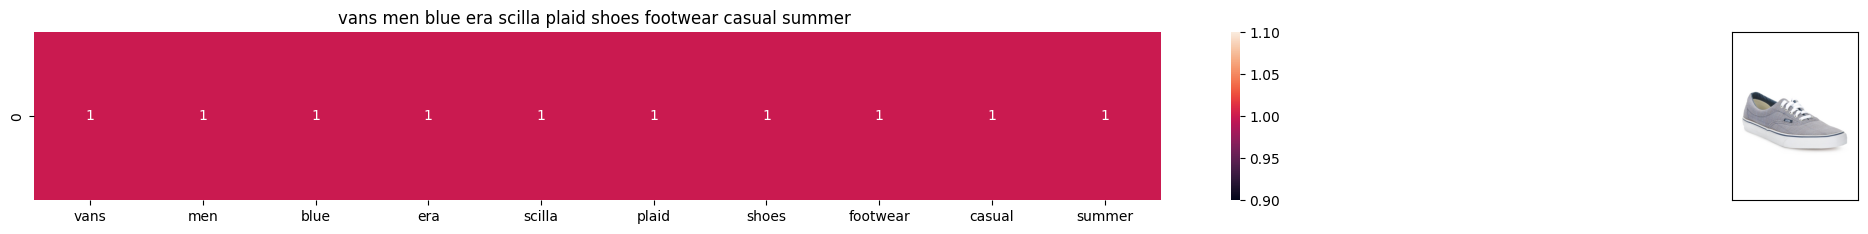

ID : 49461
Title: vans men blue era scilla plaid shoes footwear casual summer 
Euclidean similarity with the query image : 0.0


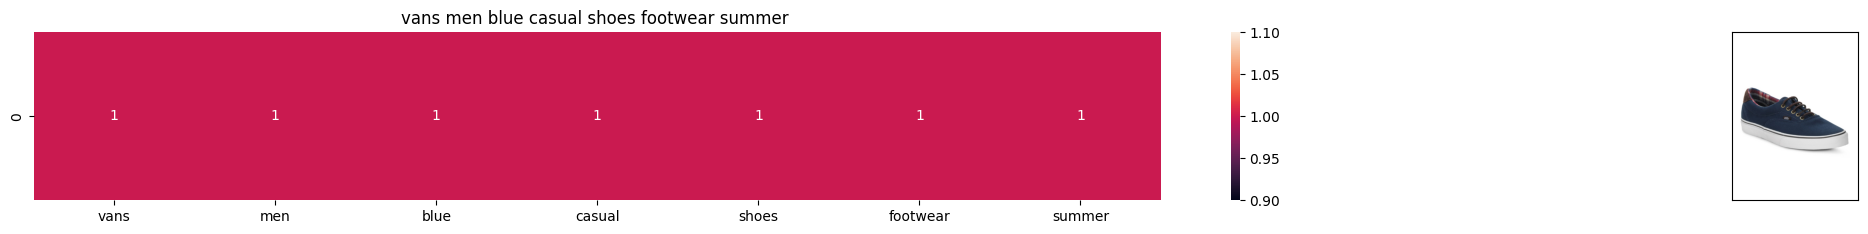

ID : 49486
Title: vans men blue casual shoes footwear summer 
Euclidean similarity with the query image : 1.7320508075688772


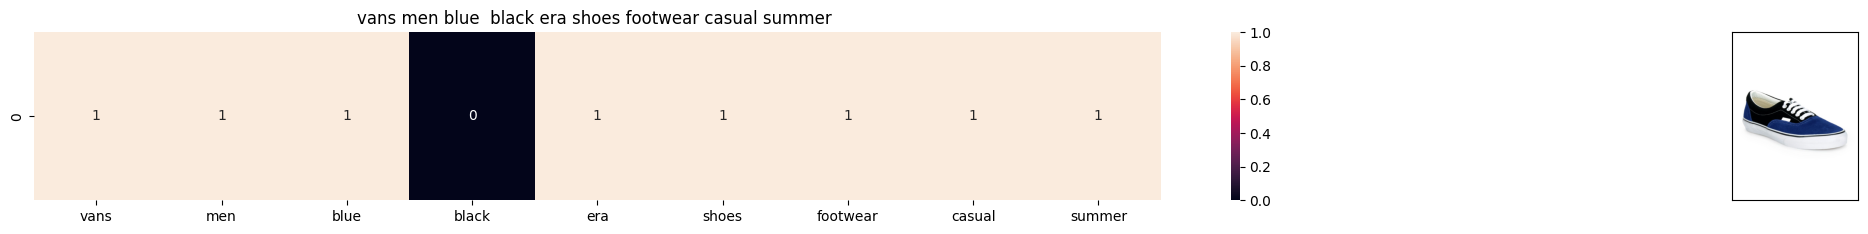

ID : 49491
Title: vans men blue  black era shoes footwear casual summer 
Euclidean similarity with the query image : 1.7320508075688772


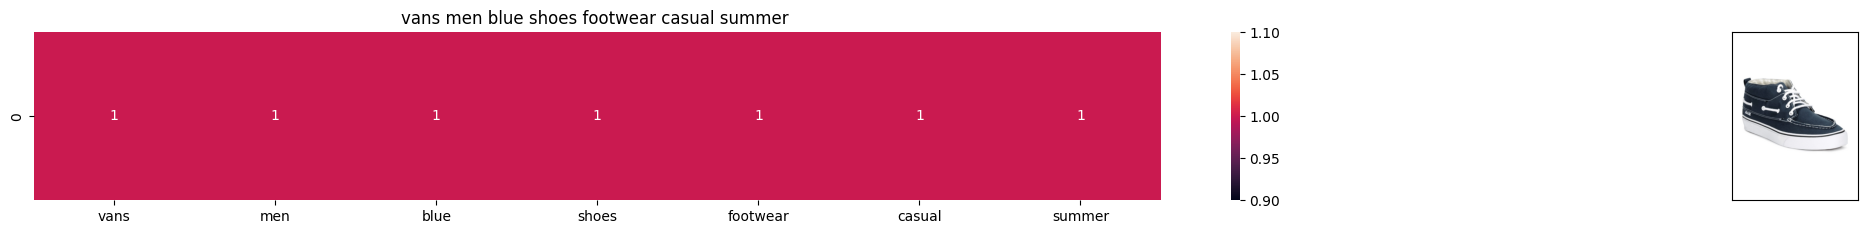

ID : 49477
Title: vans men blue shoes footwear casual summer 
Euclidean similarity with the query image : 1.7320508075688772


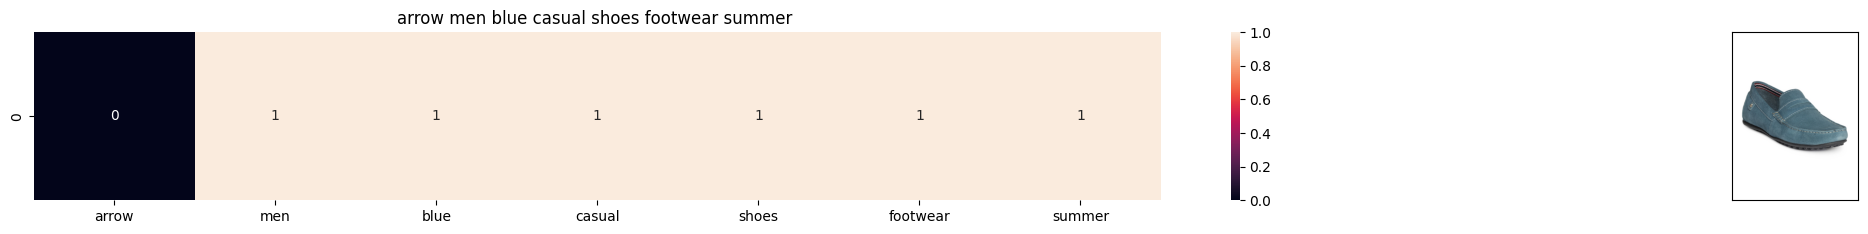

ID : 45618
Title: arrow men blue casual shoes footwear summer 
Euclidean similarity with the query image : 2.23606797749979


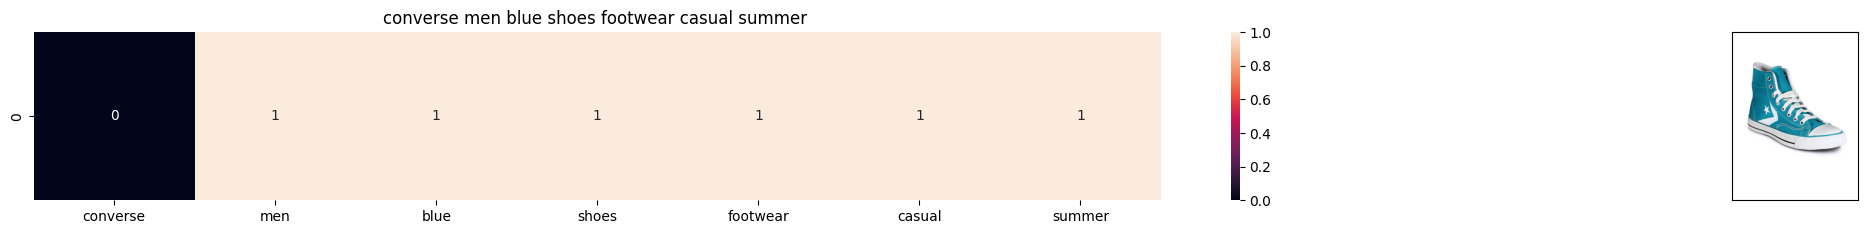

ID : 40737
Title: converse men blue shoes footwear casual summer 
Euclidean similarity with the query image : 2.23606797749979
Average euclidean distance is  1.6113813962843686


In [57]:
print('Getting the similar items for document id and number of items')
bag_of_words_model(56, 6)

## 2.TF-IDF BASED PRODUCT SIMILARITY

In [58]:
tfidf_title_vectorizer = TfidfVectorizer(min_df = 0.0)
tfidf_title_features = tfidf_title_vectorizer.fit_transform(data['productDescription'])
tf_idf_euclidean=[]
def tfidf_model(doc_id, num_results):
    L=[]
    pairwise_dist = pairwise_distances(tfidf_title_features,tfidf_title_features[doc_id])

    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    df_indices = list(data.index[indices])
    for i in range(0,len(indices)):
        L.append(data['id'].loc[df_indices[i]])
    return L

In [59]:
tfidf_title_vectorizer = TfidfVectorizer(min_df = 0.0)
tfidf_title_features = tfidf_title_vectorizer.fit_transform(data['productDescription'])
tf_idf_euclidean=[]
def tfidf_model(doc_id, num_results):
    pairwise_dist = pairwise_distances(tfidf_title_features,tfidf_title_features[doc_id])
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]
    df_indices = list(data.index[indices])

    for i in range(0,len(indices)):
        get_result(indices[i], data['productDescription'].loc[df_indices[0]], data['productDescription'].loc[df_indices[i]],data['link'].loc[df_indices[i]], 'tfidf')
        print('ID :',data['id'].loc[df_indices[i]])
        tf_idf_euclidean.append(pdists[i])
        print ('Eucliden distance from the given image :', pdists[i])
        print('='*125)
    print('Average euclidean distance is',sum(tf_idf_euclidean)/num_results)

## 3. IDF BASED PRODUCT SIMILARITY

In [60]:
idf_title_vectorizer = CountVectorizer()
idf_title_features = idf_title_vectorizer.fit_transform(data['productDescription'])

In [61]:
def n_containing(word):
    return sum(1 for blob in data['productDescription'] if word in blob.split())

def idf(word):
    return math.log(data.shape[0] / (n_containing(word)))

In [62]:
idf_euclidean=[]
def idf_model(doc_id, num_results):
    pairwise_dist = pairwise_distances(idf_title_features,idf_title_features[doc_id])
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]
    df_indices = list(data.index[indices])

    for i in range(0,len(indices)):
        get_result(indices[i],data['productDescription'].loc[df_indices[0]], data['productDescription'].loc[df_indices[i]], data['link'].loc[df_indices[i]], 'idf')
        print('ID :',data['id'].loc[df_indices[i]])
        idf_euclidean.append(pdists[i])
        print ('euclidean distance from the given image :', pdists[i])
        print('='*125)
    print('Average euclidean distance is ',sum(idf_euclidean)/num_results)

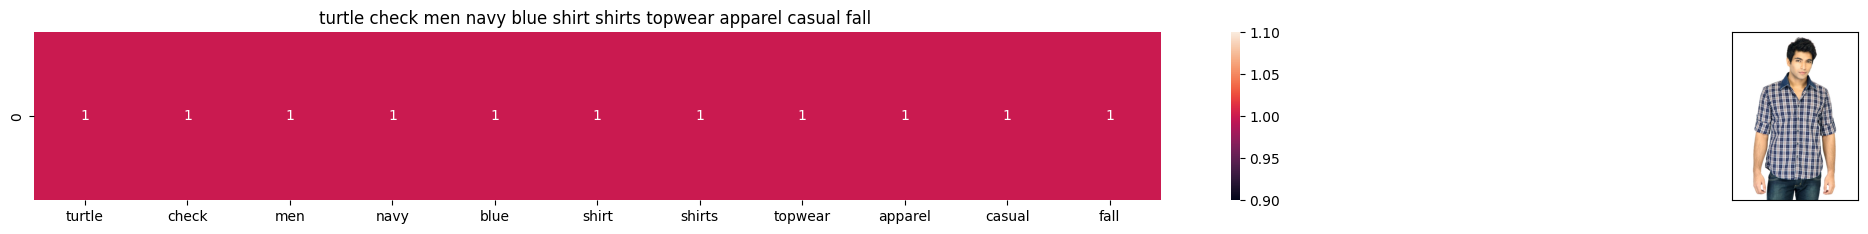

ID : 15970
euclidean distance from the given image : 0.0


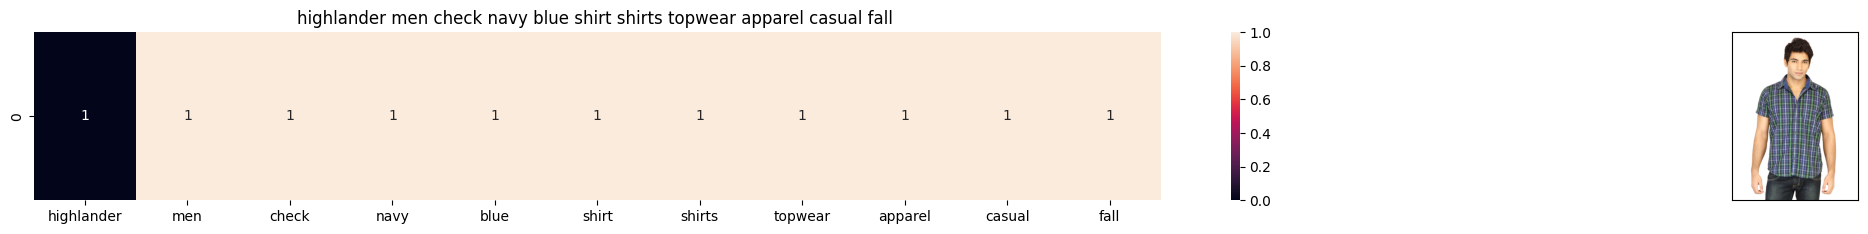

ID : 16050
euclidean distance from the given image : 1.4142135623730951


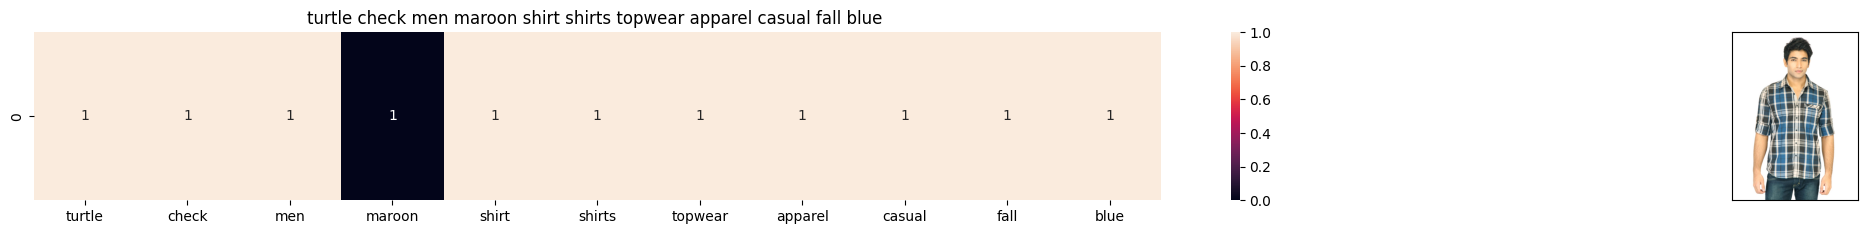

ID : 15972
euclidean distance from the given image : 1.4142135623730951


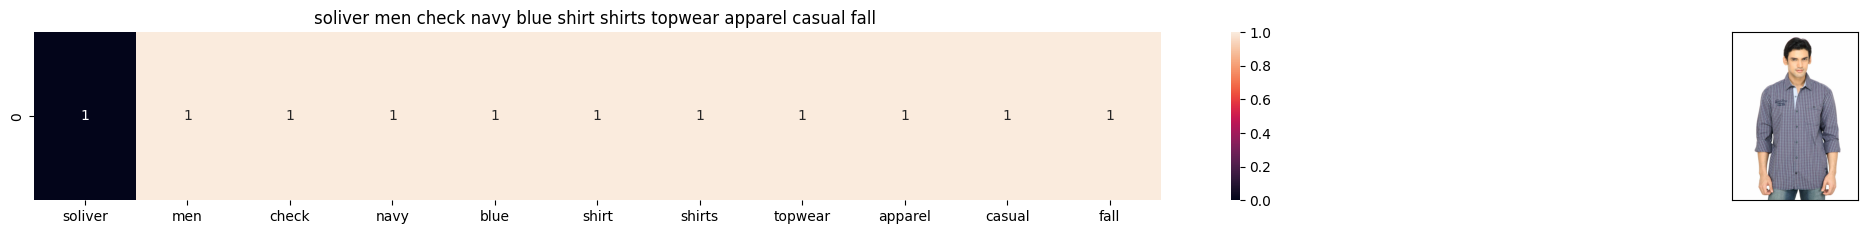

ID : 21121
euclidean distance from the given image : 1.4142135623730951


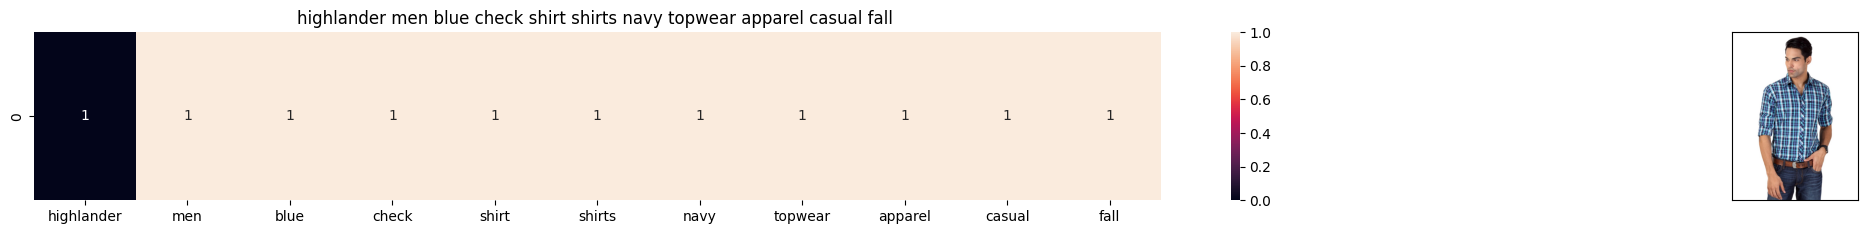

ID : 58800
euclidean distance from the given image : 1.4142135623730951
Average euclidean distance is  1.131370849898476


In [63]:
idf_model(0,5)

## 4. KNN BASED PRODUCT SIMILARITY

In [64]:
import numpy as np
import pandas as pd 
from sklearn.neighbors import NearestNeighbors

In [65]:
df.columns

Index(['id', 'gender', 'masterCategory', 'subCategory', 'articleType',
       'baseColour', 'season', 'usage', 'productDisplayName', 'link',
       'productDescription'],
      dtype='object')

In [66]:
sparse_matrix_products = df[['masterCategory', 'subCategory', 'articleType', 'baseColour', 'season', 'usage']]

In [67]:
sparse_matrix_products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21226 entries, 0 to 21225
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   masterCategory  21226 non-null  object
 1   subCategory     21226 non-null  object
 2   articleType     21226 non-null  object
 3   baseColour      21226 non-null  object
 4   season          21226 non-null  object
 5   usage           21226 non-null  object
dtypes: object(6)
memory usage: 995.1+ KB


In [68]:
sparse_matrix_products = pd.get_dummies(sparse_matrix_products)

In [69]:
model = NearestNeighbors(n_neighbors=15,
                         metric='cosine',
                         algorithm='brute',
                         n_jobs=-1)
model.fit(sparse_matrix_products)

NearestNeighbors(algorithm='brute', metric='cosine', n_jobs=-1, n_neighbors=15)

In [70]:
import pickle

# Assuming 'model' is your KNN model
with open('clothing_knn.pkl', 'wb') as f:
    pickle.dump(model, f)

In [71]:
# load the model from disk
with open('clothing_knn.pkl', 'rb') as f:
    loaded_model = pickle.load(f)

query_index = 0  # Replace 0 with the desired index value
distances, indices = loaded_model.kneighbors(sparse_matrix_products.iloc[query_index, :].values.reshape(1, -1))

query_index = 58

distances, indices = loaded_model.kneighbors(sparse_matrix_products.iloc[query_index, :].values.reshape(1, -1))

print(len(distances.flatten()))
M=[]
D=[]
for i in range(0,10):
    if i==0:
        print("Recommendation for {0}:\n".format(sparse_matrix_products.index[query_index]))
    else:
        M.append(sparse_matrix_products.index[indices.flatten()[i]])
        D.append(distances.flatten()[i])
        print("{0}: {1}, with distance of {2}".format(i,sparse_matrix_products.index[indices.flatten()[i]],distances.flatten()[i]))

15
Recommendation for 58:

1: 12475, with distance of 0.0
2: 10507, with distance of 0.0
3: 20809, with distance of 0.0
4: 19355, with distance of 0.0
5: 19928, with distance of 0.0
6: 12066, with distance of 0.0
7: 16517, with distance of 0.0
8: 1498, with distance of 0.0
9: 20053, with distance of 0.0


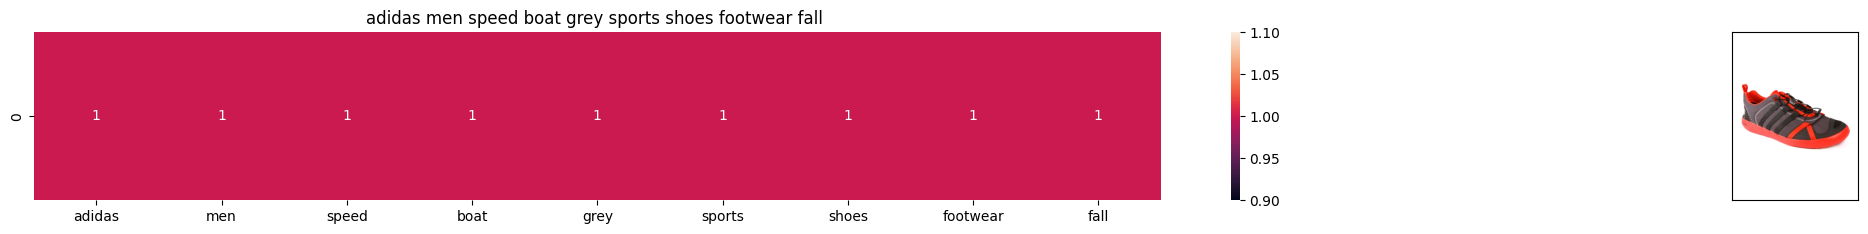

ID : 9051
Color: grey
Title: adidas men speed boat grey sports shoes footwear fall 
The distance is:  0.0


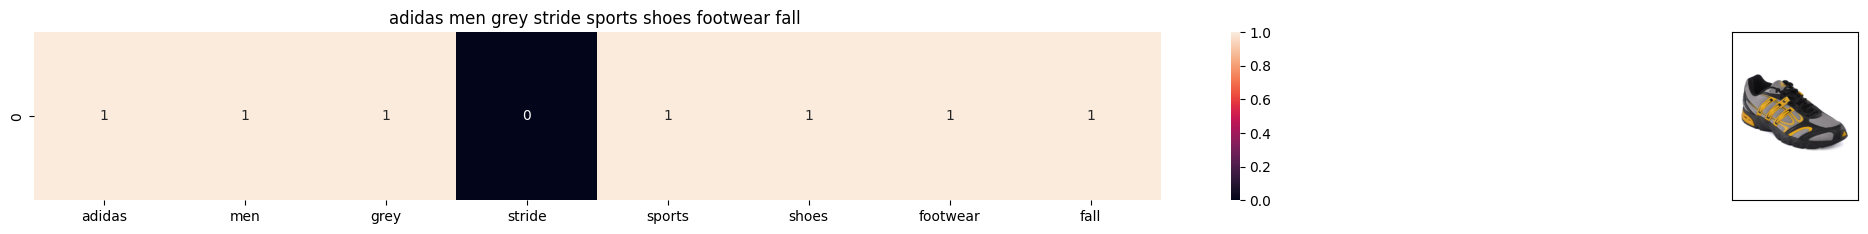

ID : 23854
Color: grey
Title: adidas men grey stride sports shoes footwear fall 
The distance is:  0.0


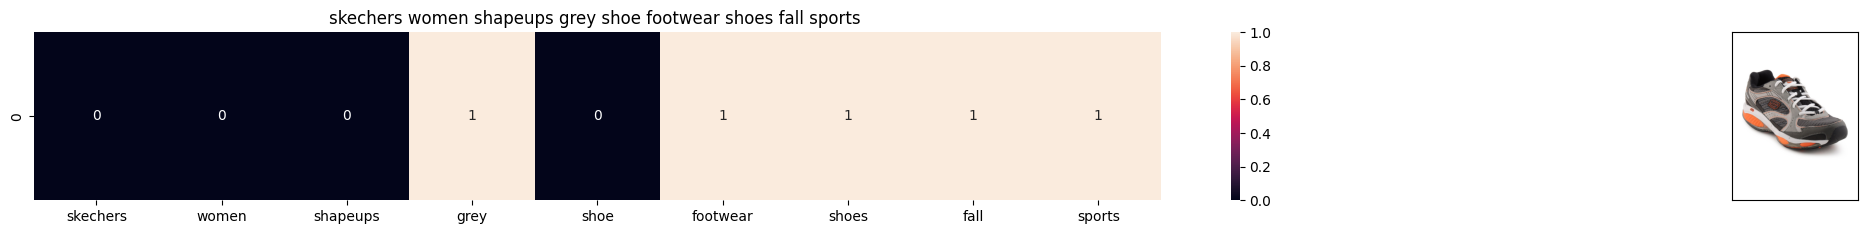

ID : 18414
Color: grey
Title: skechers women shapeups grey shoe footwear shoes fall sports 
The distance is:  0.0


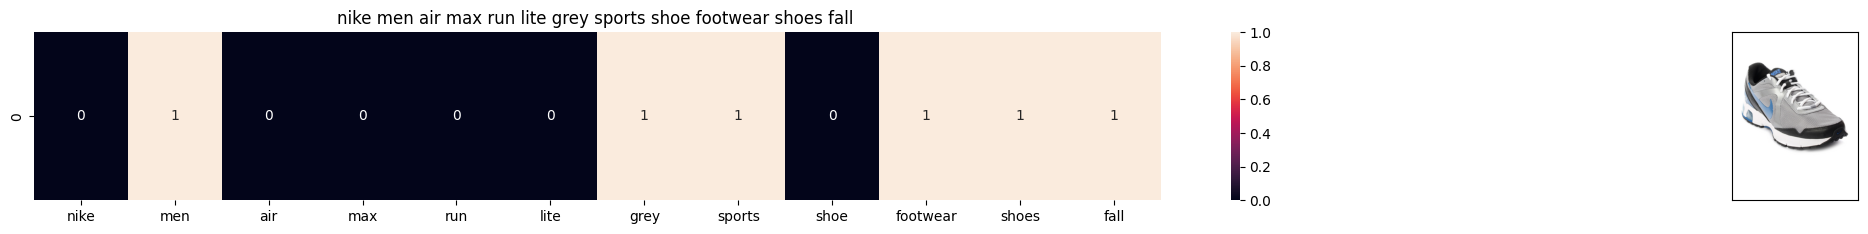

ID : 17834
Color: grey
Title: nike men air max run lite grey sports shoe footwear shoes fall 
The distance is:  0.0


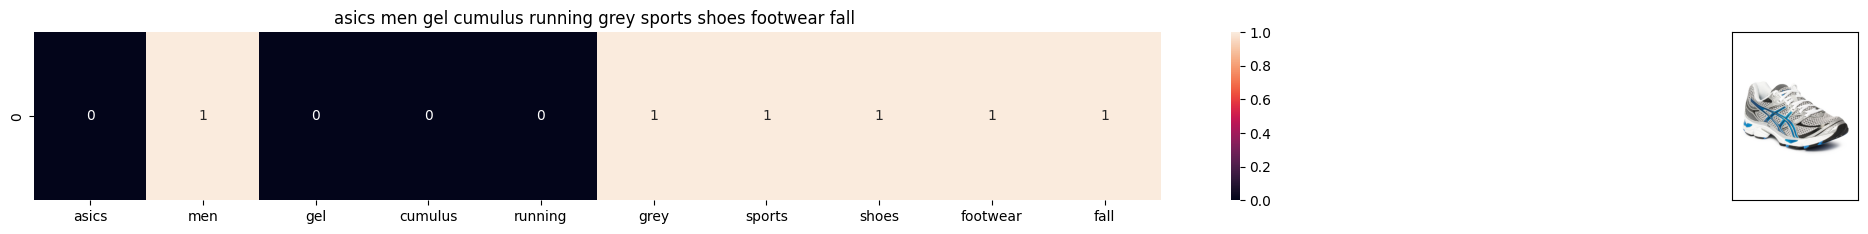

ID : 13203
Color: grey
Title: asics men gel cumulus running grey sports shoes footwear fall 
The distance is:  0.0


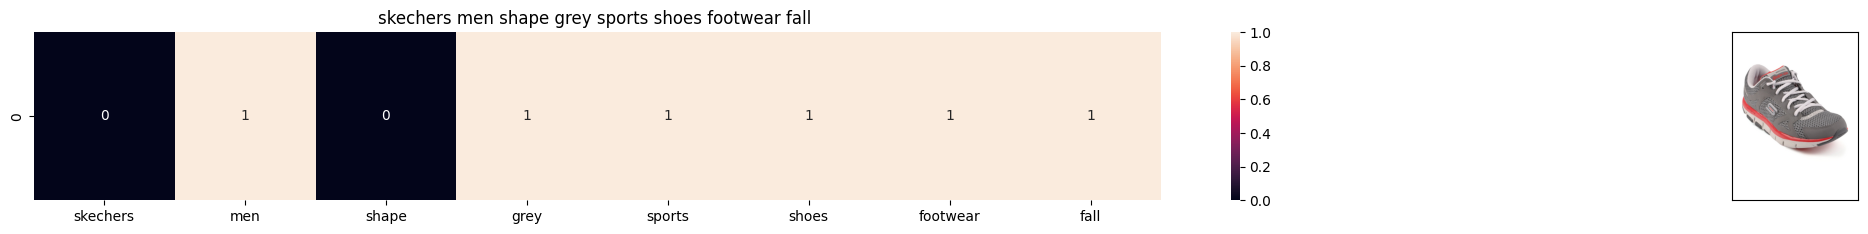

ID : 11929
Color: grey
Title: skechers men shape grey sports shoes footwear fall 
The distance is:  0.0


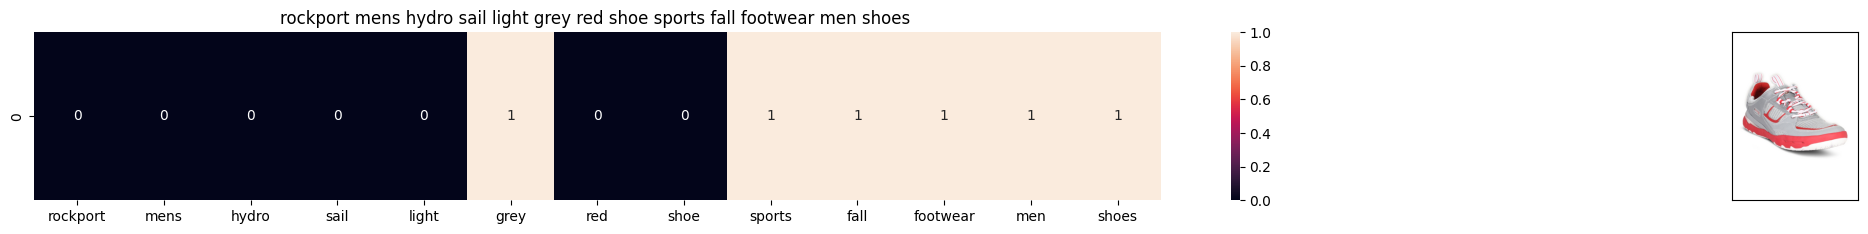

ID : 7255
Color: grey
Title: rockport mens hydro sail light grey red shoe sports fall footwear men shoes 
The distance is:  0.0


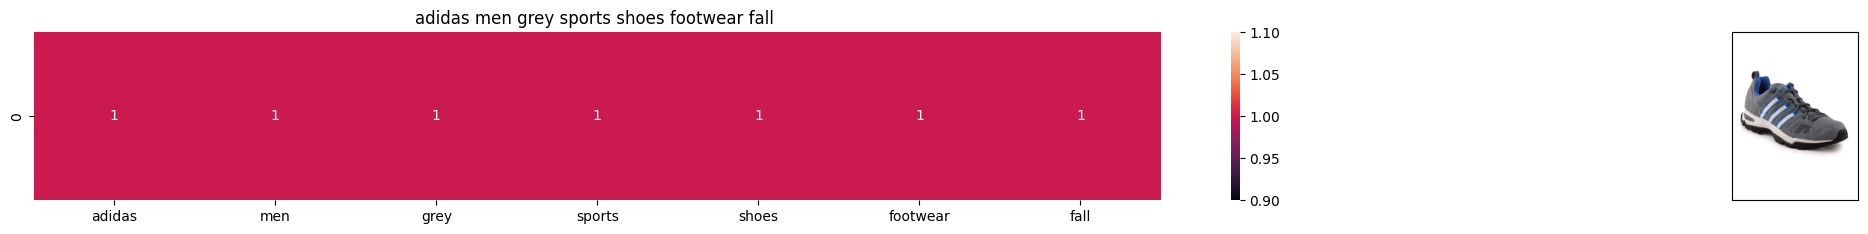

ID : 12957
Color: grey
Title: adidas men grey sports shoes footwear fall 
The distance is:  0.0


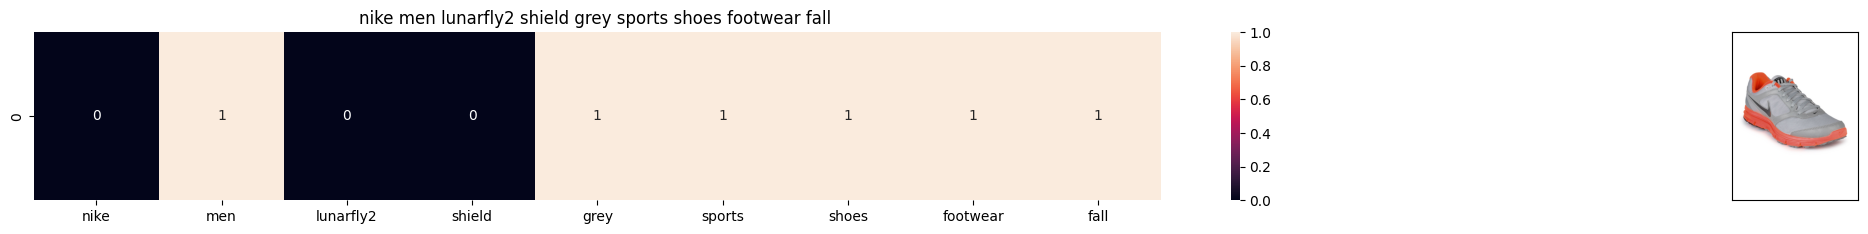

ID : 15735
Color: grey
Title: nike men lunarfly2 shield grey sports shoes footwear fall 
The distance is:  0.0


In [72]:
for i in range(0,len(M)):
    get_result(M[i],df['productDescription'].loc[M[0]], df['productDescription'].loc[M[i]], df['link'].loc[M[i]], 'bag_of_words')
    print('ID :',df['id'].loc[M[i]])
    print ('Color:', df['baseColour'].loc[M[i]])
    print ('Title:', df['productDescription'].loc[M[i]])
    print ("The distance is: ", D[i])
    print('='*60)

### Comparing the models

In [73]:
euclidean_distance=[]
num_results=20
euclidean_distance.append(sum(bag_of_words_euclidean)/num_results)
euclidean_distance.append(sum(tf_idf_euclidean)/num_results)
euclidean_distance.append(sum(idf_euclidean)/num_results)
x=euclidean_distance
y=[]
for i in range(0,47,3):
    y.append(i)

euclidean_distance

[0.48341441888531056, 0.0, 0.282842712474619]

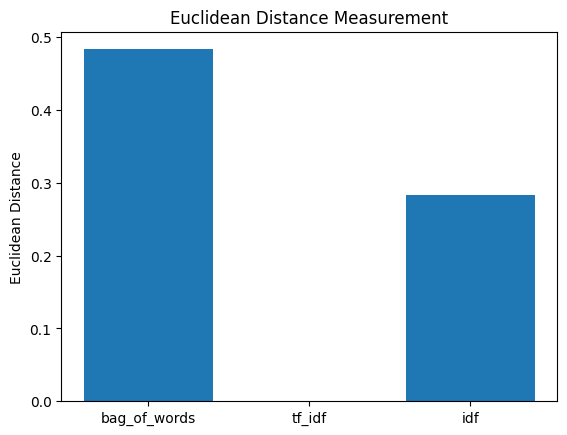

In [74]:
import matplotlib.pyplot as plt
import numpy as np

objects = ('bag_of_words', 'tf_idf', 'idf')
y_pos = np.arange(len(objects))
plt.bar(objects, x)
plt.ylabel('Euclidean Distance')
plt.title('Euclidean Distance Measurement')
plt.savefig('Comparison between clothing models.png')
plt.show()